<a href="https://colab.research.google.com/github/daspartho/fastai-part2/blob/main/matmul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Get Data

In [467]:
from pathlib import Path
import pickle, gzip, os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [468]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

In [469]:
from urllib.request import urlretrieve
if not path_gz.exists():
    urlretrieve(MNIST_URL, path_gz)

In [470]:
!ls -l data

total 16656
-rw-r--r-- 1 root root 17051982 Nov  4 17:18 mnist.pkl.gz


In [471]:
with gzip.open(path_gz, 'rb') as f:
    (x_train, y_train), (x_valid, y_valid), _ = pickle.load(f, encoding='latin-1')

In [472]:
type(x_train)

numpy.ndarray

In [473]:
ls1 = list(x_train[0])
vals = ls1[200:210]
vals

[0.0,
 0.0,
 0.0,
 0.19140625,
 0.9296875,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125]

In [474]:
def chunks(x, sz):
    for i in range(0, len(x), sz):
        yield x[i: i+sz]

In [475]:
type(chunks(vals, 5))

generator

In [476]:
list(chunks(vals, 5))

[[0.0, 0.0, 0.0, 0.19140625, 0.9296875],
 [0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]]

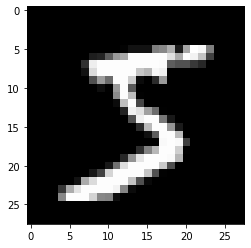

In [477]:
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(list(chunks(ls1, 28)))

In [478]:
from itertools import islice

In [479]:
it = iter(vals)
it

In [480]:
list(islice(it, 5))

[0.0, 0.0, 0.0, 0.19140625, 0.9296875]

In [481]:
it = iter(ls1)
img = list(iter(lambda: list(islice(it, 28)), []))

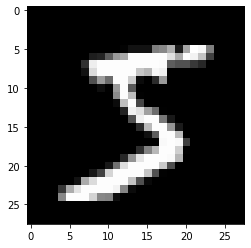

In [482]:
plt.imshow(img)

### Matrix and Tensor

In [483]:
img[20][15]

0.98828125

In [484]:
class Matrix:
    def __init__(self, xs):
        self.xs = xs
    def __getitem__(self, idxs):
        return self.xs[idxs[0]][idxs[1]]

In [485]:
m = Matrix(img)
m[20, 15]

0.98828125

In [486]:
import torch
from torch import tensor

In [487]:
tensor(vals)

tensor([0.0000, 0.0000, 0.0000, 0.1914, 0.9297, 0.9883, 0.9883, 0.9883, 0.9883,
        0.9883])

In [488]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
x_train.shape

torch.Size([50000, 784])

In [489]:
x_train.type()

'torch.FloatTensor'

In [490]:
imgs = x_train.reshape(-1, 28, 28)
imgs.shape

torch.Size([50000, 28, 28])

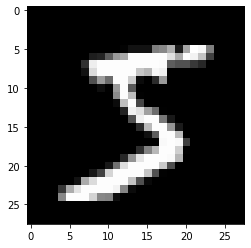

In [491]:
plt.imshow(imgs[0])

In [492]:
imgs[0,20,15]

tensor(0.9883)

In [493]:
y_train, y_train.shape

(tensor([5, 0, 4,  ..., 8, 4, 8]), torch.Size([50000]))

In [494]:
y_train.min(), y_train.max()

(tensor(0), tensor(9))

### Random Numbers

In [495]:
rnd_state = None
def seed(a):
    global rnd_state
    a, x = divmod(a, 30268)
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)
    rnd_state = int(x)+1, int(y)+1, int(z)+1

In [496]:
seed(457428938475)
rnd_state

(4976, 20238, 499)

In [497]:
def rand():
    global rnd_state
    x, y, z = rnd_state
    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323
    rnd_state = x,y,z
    return (x/30269 + y/30307 + z/30323) % 1.0

In [498]:
rand(),rand(),rand()

(0.7645251082582081, 0.7920889799553945, 0.06912886811267205)

In [499]:
if os.fork(): 
    print(f'In parent: {rand()}')
else:
    print(f'In child: {rand()}')
    os._exit(os.EX_OK)

In parent: 0.9559050644103264
In child: 0.9559050644103264


In [500]:
if os.fork(): 
    print(f'In parent: {torch.rand(1)}')
else:
    print(f'In child: {torch.rand(1)}')
    os._exit(os.EX_OK)

In parent: tensor([0.1021])
In child: tensor([0.1021])


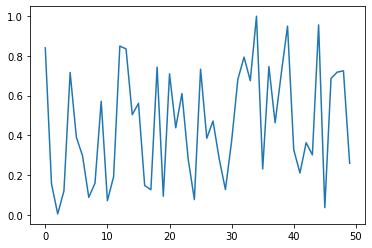

In [501]:
plt.plot([rand() for _ in range(50)])

(array([ 959.,  972., 1036., 1019., 1037.,  971.,  997., 1000., 1036.,
         973.]),
 array([6.60514437e-06, 1.00005135e-01, 2.00003666e-01, 3.00002196e-01,
        4.00000726e-01, 4.99999256e-01, 5.99997787e-01, 6.99996317e-01,
        7.99994847e-01, 8.99993378e-01, 9.99991908e-01]),
 <a list of 10 Patch objects>)

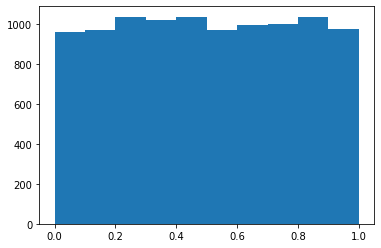

In [502]:
plt.hist([rand() for _ in range(10000)])

In [503]:
%timeit -n 10 list(chunks([rand() for _ in range(7840)], 10))

4.14 ms ± 245 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [504]:
%timeit -n 10 torch.randn(784,10)

The slowest run took 8.87 times longer than the fastest. This could mean that an intermediate result is being cached.
109 µs ± 123 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Matrix Multiplication

In [505]:
weights = torch.randn(784, 10)
bias = torch.randn(10)

In [506]:
m1 = x_valid[:5]
m2 = weights
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [507]:
m1r, m1c = m1.shape
m2r, m2c = m2.shape

In [508]:
t1=torch.zeros(m1r, m2c)
t1.shape

torch.Size([5, 10])

In [509]:
t1

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [510]:
for i in range(m1r):
    for j in range(m2c):
        for k in range(m1c): # or m2r (both same)
            t1[i, j] += m1[i,k] * m2[k, j]

In [511]:
t1

tensor([[ -0.0831,  -4.5006,  14.4418,   3.1894,   4.9615,  -8.9868,   4.2334,
           4.2903,  -5.2072, -10.5840],
        [ -2.4945,  -1.0273,   6.5773,   1.5589,   8.7855,  -0.8578,  11.9038,
           3.1880,   8.5353, -15.5250],
        [  5.1811,  -6.9883,  15.7716,   3.2956,  -3.8158,  -0.2620,   1.7106,
          11.6672,   1.2099,  13.7941],
        [ -2.6846,   1.9858,   1.7038,   6.3272,  -4.6149,  12.0997,  -2.2761,
           3.1379,   1.4885,  -3.2497],
        [  6.6054,  -2.7104,  11.3775,   7.7875,   3.2351,  12.3507,  -7.4660,
          10.4673,  12.1235,   1.0778]])

In [512]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): # or br (both same)
                c[i, j] += a[i,k] * b[k, j]
    return c

In [513]:
matmul(m1, m2)

tensor([[ -0.0831,  -4.5006,  14.4418,   3.1894,   4.9615,  -8.9868,   4.2334,
           4.2903,  -5.2072, -10.5840],
        [ -2.4945,  -1.0273,   6.5773,   1.5589,   8.7855,  -0.8578,  11.9038,
           3.1880,   8.5353, -15.5250],
        [  5.1811,  -6.9883,  15.7716,   3.2956,  -3.8158,  -0.2620,   1.7106,
          11.6672,   1.2099,  13.7941],
        [ -2.6846,   1.9858,   1.7038,   6.3272,  -4.6149,  12.0997,  -2.2761,
           3.1379,   1.4885,  -3.2497],
        [  6.6054,  -2.7104,  11.3775,   7.7875,   3.2351,  12.3507,  -7.4660,
          10.4673,  12.1235,   1.0778]])

In [514]:
%time _=matmul(m1, m2)

CPU times: user 654 ms, sys: 675 µs, total: 655 ms
Wall time: 654 ms


### Numba

In [515]:
from numba import njit

In [516]:
@njit
def dot(a, b):
    res = 0
    for i in range(len(a)):
        res+= a[i]*b[i]
    return res

In [517]:
from numpy import array
a = array([1,2,3])
b = array([1,2,3])

In [518]:
%time dot(a, b)

CPU times: user 88.8 ms, sys: 5.05 ms, total: 93.9 ms
Wall time: 91.8 ms


14

In [519]:
%time dot(a, b)

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 10.3 µs


14

In [520]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i, j] = dot(a[i,:],b[:,j])
    return c

In [521]:
m1a, m2a = m1.numpy(), m2.numpy()

In [522]:
from fastcore.test import *

In [523]:
test_close(t1, matmul(m1a, m2a))

In [524]:
%timeit -n 10 matmul(m1a, m2a)

591 µs ± 104 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Elementwise Operations

In [525]:
a = tensor([10, 8, 6])
b = tensor([7, 8, 9])
a,b

(tensor([10,  8,  6]), tensor([7, 8, 9]))

In [526]:
a+b

tensor([17, 16, 15])

In [527]:
a*b

tensor([70, 64, 54])

In [528]:
(a<b)

tensor([False, False,  True])

In [529]:
(a<b).float().mean()

tensor(0.3333)

In [530]:
m = tensor([
    [1,2,3],
    [4,5,6],
    [7,8,9]
])

In [531]:
fnorm = (m*m).sum().sqrt()
fnorm

tensor(16.8819)

In [532]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i, j] = (a[i,:]*b[:,j]).sum()
    return c

In [533]:
test_close(t1, matmul(m1, m2))

In [534]:
%timeit -n 10 matmul(m1, m2)

1.09 ms ± 377 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [535]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            c[i, j] = torch.dot(a[i,:],b[:,j])
    return c

In [536]:
test_close(t1, matmul(m1, m2))

In [537]:
%timeit -n 10 matmul(m1, m2)

789 µs ± 185 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Broadcasting

In [538]:
a

tensor([10,  8,  6])

In [539]:
a>0

tensor([True, True, True])

In [540]:
a+1

tensor([11,  9,  7])

In [541]:
m

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [542]:
m*3

tensor([[ 3,  6,  9],
        [12, 15, 18],
        [21, 24, 27]])

In [543]:
a+m

tensor([[11, 10,  9],
        [14, 13, 12],
        [17, 16, 15]])

In [544]:
t = a.expand_as(m)
t

tensor([[10,  8,  6],
        [10,  8,  6],
        [10,  8,  6]])

In [545]:
m+t

tensor([[11, 10,  9],
        [14, 13, 12],
        [17, 16, 15]])

In [546]:
t.storage()

 10
 8
 6
[torch.storage._TypedStorage(dtype=torch.int64, device=cpu) of size 3]

In [547]:
a.unsqueeze(0)

tensor([[10,  8,  6]])

In [548]:
a[None,:]

tensor([[10,  8,  6]])

In [549]:
a.unsqueeze(1)

tensor([[10],
        [ 8],
        [ 6]])

In [550]:
a[:, None]

tensor([[10],
        [ 8],
        [ 6]])

In [551]:
a[:, None].expand_as(m)

tensor([[10, 10, 10],
        [ 8,  8,  8],
        [ 6,  6,  6]])

In [552]:
m + a[:, None]

tensor([[11, 12, 13],
        [12, 13, 14],
        [13, 14, 15]])

In [553]:
a[:,None] * a[None, :]

tensor([[100,  80,  60],
        [ 80,  64,  48],
        [ 60,  48,  36]])

In [554]:
digit = m1[0]
digit.shape, m2.shape

(torch.Size([784]), torch.Size([784, 10]))

In [555]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        c[i] = (a[i,:,None] * b).sum(dim=0)
    return c

In [556]:
test_close(t1,matmul(m1, m2))

In [557]:
%timeit -n 10 _=matmul(m1, m2)

305 µs ± 182 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [558]:
pred = matmul(x_train, weights)
pred.shape

torch.Size([50000, 10])

In [559]:
%time _=matmul(x_train, weights)

CPU times: user 1.11 s, sys: 10.1 ms, total: 1.12 s
Wall time: 1.13 s


### Einstein summation

In [560]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [561]:
mr = torch.einsum('ik,kj->ikj', m1, m2)
mr.shape

torch.Size([5, 784, 10])

In [562]:
mr.sum(dim=1)

tensor([[ -0.0831,  -4.5006,  14.4418,   3.1894,   4.9615,  -8.9868,   4.2334,
           4.2903,  -5.2072, -10.5840],
        [ -2.4945,  -1.0273,   6.5773,   1.5589,   8.7855,  -0.8578,  11.9038,
           3.1880,   8.5353, -15.5250],
        [  5.1811,  -6.9883,  15.7716,   3.2956,  -3.8158,  -0.2620,   1.7106,
          11.6672,   1.2099,  13.7941],
        [ -2.6846,   1.9858,   1.7038,   6.3272,  -4.6149,  12.0997,  -2.2761,
           3.1379,   1.4885,  -3.2497],
        [  6.6054,  -2.7104,  11.3775,   7.7875,   3.2351,  12.3507,  -7.4660,
          10.4673,  12.1235,   1.0778]])

In [563]:
torch.einsum('ik,kj->ij', m1, m2)

tensor([[ -0.0831,  -4.5006,  14.4418,   3.1894,   4.9615,  -8.9868,   4.2334,
           4.2903,  -5.2072, -10.5840],
        [ -2.4945,  -1.0273,   6.5773,   1.5589,   8.7855,  -0.8578,  11.9038,
           3.1880,   8.5353, -15.5250],
        [  5.1811,  -6.9883,  15.7716,   3.2956,  -3.8158,  -0.2620,   1.7106,
          11.6672,   1.2099,  13.7941],
        [ -2.6846,   1.9858,   1.7038,   6.3272,  -4.6149,  12.0997,  -2.2761,
           3.1379,   1.4885,  -3.2497],
        [  6.6054,  -2.7104,  11.3775,   7.7875,   3.2351,  12.3507,  -7.4660,
          10.4673,  12.1235,   1.0778]])

In [564]:
def matmul(a, b):
    return torch.einsum('ik,kj->ij', a, b)

In [565]:
test_close(pred, matmul(x_train, weights),eps=1e-3)

In [566]:
%timeit -n 5 _=matmul(x_train, weights)

24.7 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


### PyTorch matmul

In [567]:
test_close(pred, x_train@weights, eps=1e-3)

In [568]:
%timeit -n 5 _=torch.matmul(x_train, weights)

23.6 ms ± 793 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


### CUDA

In [569]:
def matmul(grid, a, b, c):
    i, j=grid
    tmp = 0
    for k in range(a.shape[1]): 
        tmp += a[i,k] * b[k,j]
    c[i,j] = tmp

In [570]:
res = torch.zeros(5, 10)
matmul((0,0), m1, m2, res)
res

tensor([[-0.0831,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000]])

In [571]:
def launch_kernel(kernel, grid_x, grid_y, *args, **kwargs):
    for i in range(grid_x):
        for j in range(grid_y):
            kernel((i,j), *args, **kwargs)

In [572]:
res = torch.zeros(5, 10)
launch_kernel(matmul, 5,10, m1,m2, res)
res

tensor([[ -0.0831,  -4.5006,  14.4418,   3.1894,   4.9615,  -8.9868,   4.2334,
           4.2903,  -5.2072, -10.5840],
        [ -2.4945,  -1.0273,   6.5773,   1.5589,   8.7855,  -0.8578,  11.9038,
           3.1880,   8.5353, -15.5250],
        [  5.1811,  -6.9883,  15.7716,   3.2956,  -3.8158,  -0.2620,   1.7106,
          11.6672,   1.2099,  13.7941],
        [ -2.6846,   1.9858,   1.7038,   6.3272,  -4.6149,  12.0997,  -2.2761,
           3.1379,   1.4885,  -3.2497],
        [  6.6054,  -2.7104,  11.3775,   7.7875,   3.2351,  12.3507,  -7.4660,
          10.4673,  12.1235,   1.0778]])

In [573]:
from numba import cuda

In [574]:
@cuda.jit
def matmul(a,b,c):
    i, j = cuda.grid(2)
    if i < c.shape[0] and j < c.shape[1]:
        tmp = 0
        for k in range(a.shape[1]): 
            tmp += a[i,k] * b[k,j]
        c[i,j] = tmp

In [575]:
import numpy as np
r = np.zeros(pred.shape)
m1g, m2g, rg = map(cuda.to_device, (x_train, weights, r))

In [576]:
import math
TPB = 16
rr,rc = r.shape
blockspergrid = (math.ceil(rr / TPB), math.ceil(rc / TPB))
blockspergrid

(3125, 1)

In [577]:
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()
test_close(pred, r, eps=1e-3)

In [578]:
%%timeit -n 10
matmul[blockspergrid, (TPB,TPB)](m1g,m2g,rg)
r = rg.copy_to_host()

11.5 ms ± 3.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [579]:
m1c, m2c = x_train.cuda(), weights.cuda()

In [580]:
r = (m1c@m2c).cpu()

In [581]:
%timeit -n 10 r=(m1c@m2c).cpu()

2.03 ms ± 37.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


and now i know how to do matrix multiplication :)